In [1]:
using LinearAlgebra, Parameters, Plots
gr(fmt = :png); # save plots in .png

# Solving HJB for neoclassical growth models using implicit method

Presented by Chiyoung Ahn (@chiyahn) -- based on Ben Moll's notes in http://www.princeton.edu/~moll/HACTproject/HACT_Additional_Codes.pdf and  http://www.princeton.edu/~moll/HACTproject/HJB_NGM_implicit.m


# Setup

## Production function

In [2]:
A_productivity = 1.0
α = 0.3 
F(k) = A_productivity*k^α;

## Utility function

In [3]:
γ = 2.0
u(c) = c^(1-γ)/(1-γ) 
u_prime(c) = c^(-γ)

u_prime (generic function with 1 method)

## Consumption function by inverse

In [4]:
c(v_prime) = v_prime^(-1/γ); # consumption by derivative of value function at certain k

## Parameters and grids

In [5]:
# ρ: utility discount rate
# δ: capital discount rate
# γ: CRRA parameter
# F: production function that maps k to a real number
# u: utility function that maps c to a real number
# u_prime: derivative of utility function that maps c to a real number
# c: consumption function that maps v_prime (derivative of v at certain k) to a real number
params = (ρ = 0.05, δ = 0.05, γ = γ, F = F, u = u, u_prime = u_prime, c = c)

(ρ = 0.05, δ = 0.05, γ = 2.0, F = F, u = u, u_prime = u_prime, c = c)

In [6]:
# ks: grids for states (k) -- assume uniform grids
# maxit: maximum number of iterations
# verbose: boolean that ables/disables a verbose option
k_ss = (α*A_productivity/(params.ρ+params.δ))^(1/(1-α))
settings = (ks = range(0.001*k_ss, stop = 2*k_ss, length = 10000),
            maxit = 1000, verbose = false)

(ks = 0.0048039866566730914:0.0009604129739663476:9.607973313346182, maxit = 1000, verbose = false)

# Solve

In [7]:
@unpack ρ, δ, γ, F, u, u_prime, c = params
@unpack ks, maxit, verbose = settings

P = length(ks)
Δ = ks[2] - ks[1] # assume uniform grids

vs = (A_productivity .* settings.ks .^ α) .^ (1-params.γ) / (1-params.γ) / params.ρ; # initial guess
cs = zeros(P) # save control (consumption) plan as well

# begin iterations
for n in 1:maxit
    dv = diff(vs) ./ Δ
    dv_f = [dv; NaN] # forward difference
    dv_b = [NaN; dv] # backward difference
    dv_0 = u_prime.(F.(ks) - δ.*ks)
    
    # define the corresponding drifts
    drift_f = F.(ks) - δ.*ks - c.(dv_f)
    drift_b = F.(ks) - δ.*ks - c.(dv_b)

    # steady states at boundary
    drift_f[end] = 0.0
    drift_b[1] = 0.0
    
    # compute consumptions and corresponding u(v)
    I_f = drift_f .> 0.0
    I_b = drift_b .< 0.0
    I_0 = 1 .- I_f-I_b
    
    dv_upwind = dv_f.*I_f + dv_b.*I_b + dv_0.*I_0;
    cs = c.(dv_upwind)
    us = u.(cs)

    # define the matrix A
    drift_f_upwind = max.(drift_f, 0.0) ./ Δ
    drift_b_upwind = min.(drift_b, 0.0) ./ Δ
    A = LinearAlgebra.Tridiagonal(-drift_b_upwind[2:P], 
            (-drift_f_upwind + drift_b_upwind), 
            drift_f_upwind[1:(P-1)]) 
    
    vs_new = (Diagonal(fill((ρ + 1/Δ), P)) - A) \ (us + vs ./ Δ)
    if (verbose)
        @show maximum(abs.(vs - vs_new))    
    end
    vs = vs_new
end

# Plots

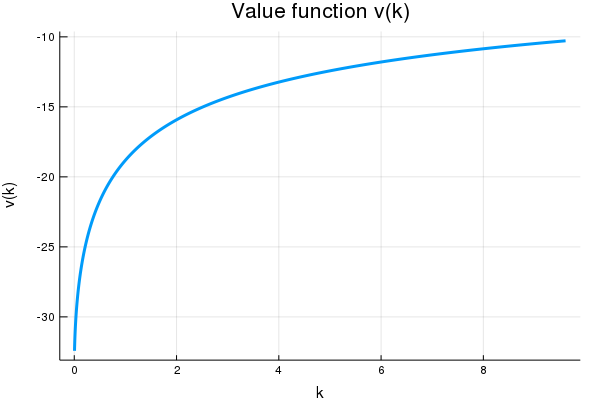

In [8]:
plot(ks, vs,
    linewidth = 3,
    title="Value function v(k)",xaxis="k",yaxis="v(k)",legend=false)


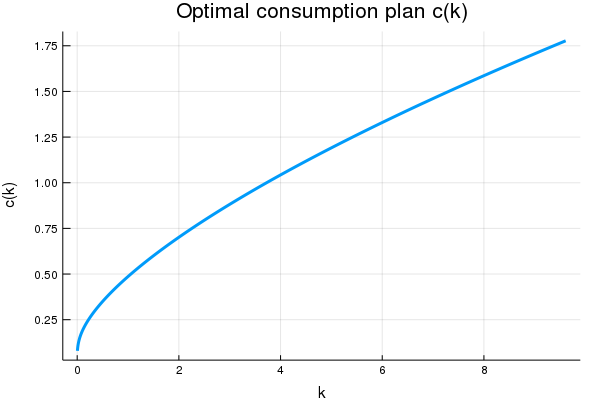

In [9]:
plot(ks, cs,
    lw = 3,
    title="Optimal consumption plan c(k)",xaxis="k",yaxis="c(k)",legend=false)

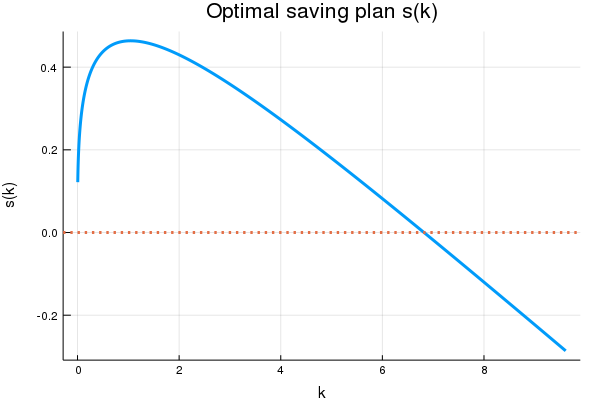

In [10]:
savings = F.(ks) - δ*ks - cs
plot(ks, savings,
    linewidth = 3,
    title="Optimal saving plan s(k)",xaxis="k",yaxis="s(k)",legend=false)
plot!([.0], st = :hline, linestyle = :dot, lw = 3) # zero saving line